In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## 데이터 설명
- 리그오브레전드 14시즌 솔로랭크 마스터 ~ 챌린저 구간 무작위 매치 데이터 약 12000건

In [2]:
data = pd.read_csv('preprocessed_data2.csv', index_col=0)

In [3]:
data

,metadata.matchId,blue_win,blue_objectives.baron.first,blue_objectives.baron.kills,blue_objectives.champion.first,blue_objectives.champion.kills,blue_objectives.dragon.first,blue_objectives.dragon.kills,blue_objectives.horde.first,blue_objectives.horde.kills,...,red_objectives.tower.first,red_objectives.tower.kills,horde_kills,index,blue_ping,red_ping,blue_visionScore,blue_visionWardsBoughtInGame,red_visionScore,red_visionWardsBoughtInGame
0,KR_6897835155,False,False,0,False,23,False,2,True,6,...,False,8,6,0,29.4,108.2,36.2,5.2,48.0,3.0
1,KR_6900635803,True,False,0,False,36,False,2,True,6,...,False,1,6,0,44.4,23.0,29.8,4.2,25.0,2.4
2,KR_6903010835,True,True,1,True,38,False,2,True,6,...,False,2,6,0,41.4,36.0,32.4,2.6,34.2,3.4
3,KR_6897507607,False,False,0,True,40,True,2,True,5,...,False,11,4,0,57.6,46.8,46.2,4.0,40.2,4.8
4,KR_6894687696,False,False,0,False,7,False,0,True,3,...,True,4,0,0,17.6,11.4,10.6,1.6,16.4,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,KR_6897632585,False,False,0,False,23,False,0,False,1,...,True,10,-4,0,23.6,57.8,25.2,2.8,38.4,5.2
12364,KR_6913727391,True,False,0,True,18,True,2,True,6,...,False,0,6,0,19.2,15.6,14.2,2.6,12.4,0.6
12365,KR_6894562023,True,True,2,True,48,True,3,False,0,...,True,4,-6,0,55.6,69.8,40.0,5.2,40.8,4.6
12366,KR_6894562023,True,True,2,True,48,True,3,False,0,...,True,4,-6,0,55.6,69.8,40.0,5.2,40.8,4.6


## 가설
- 시즌이 바뀌고 협곡의 변화가 생김으로 인해서 레드팀의 승률이 낮을 것이라 예상
- 상위 티어이므로 핑이 제 역할을 하여 핑을 많이 찍을수록 승률이 높을 것이다.
- 시야는 게임에서 가장 중요한 요소 중 하나이므로 모든 요소에 높은 상관관계를 갖고 있을 것이다
- 새로생긴 공허유충의 효과로 인해서 용보다 유충을 상대보다 많이 먹을 수록 승률이 높아질 것이다

/Users/raphaelseo/Library/Caches/pypoetry/virtualenvs/data-analysis-GxIBxRoh-py3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/raphaelseo/Library/Caches/pypoetry/virtualenvs/data-analysis-GxIBxRoh-py3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='blue_win', ylabel='count'>

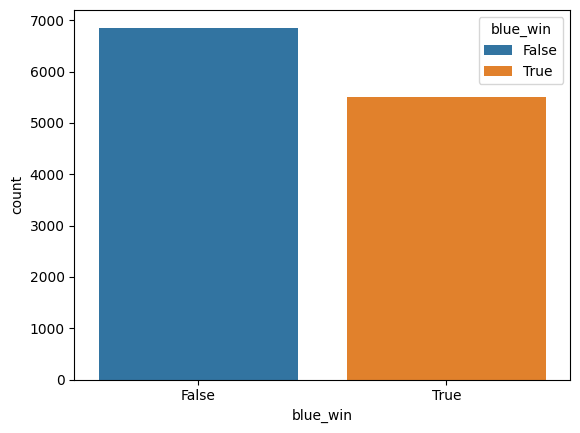

In [53]:
sns.countplot(data, x=data.blue_win, hue=data.blue_win)

### 승률 가설
- 레드팀 바텀이 힘들어졌다고 생각하여 승률이 낮을 것이라 예상했지만, 무작위로 뽑은 데이터 약 12000건을 분석한 결과 레드팀의 승률이 높았음

In [4]:
data = data.drop(['metadata.matchId', 'index'], axis=1)

In [5]:
data = data.drop(['blue_objectives.horde.kills', 'red_objectives.horde.kills'],axis=1)

### Feature Engineering

In [6]:
# 와드 구매 데이터를 각 팀의 갯수를 뺴서 하나의 컬럼으로 변경
data['ward_diff'] = data['blue_visionWardsBoughtInGame'] - data['red_visionWardsBoughtInGame']

In [7]:
data = data.drop(['blue_visionWardsBoughtInGame', 'red_visionWardsBoughtInGame'], axis=1)

In [8]:
data.columns

Index(['blue_win', 'blue_objectives.baron.first',
       'blue_objectives.baron.kills', 'blue_objectives.champion.first',
       'blue_objectives.champion.kills', 'blue_objectives.dragon.first',
       'blue_objectives.dragon.kills', 'blue_objectives.horde.first',
       'blue_objectives.inhibitor.first', 'blue_objectives.inhibitor.kills',
       'blue_objectives.riftHerald.first', 'blue_objectives.riftHerald.kills',
       'blue_objectives.tower.first', 'blue_objectives.tower.kills',
       'red_objectives.baron.first', 'red_objectives.baron.kills',
       'red_objectives.champion.first', 'red_objectives.champion.kills',
       'red_objectives.dragon.first', 'red_objectives.dragon.kills',
       'red_objectives.horde.first', 'red_objectives.inhibitor.first',
       'red_objectives.inhibitor.kills', 'red_objectives.riftHerald.first',
       'red_objectives.riftHerald.kills', 'red_objectives.tower.first',
       'red_objectives.tower.kills', 'horde_kills', 'blue_ping', 'red_ping',
     

In [9]:
# 시야점수도 마찬가지로 팀의 차이로 변경하여 컬럼을 줄임
data['vision_score_diff'] = data['blue_visionScore'] - data['red_visionScore']

In [10]:
data = data.drop(['blue_visionScore', 'red_visionScore'], axis=1)

In [11]:
# 전령을 처음 죽이는 것과 죽인 횟수는 동일함으로 하나를 제거
data = data.drop(['blue_objectives.riftHerald.first', 'red_objectives.riftHerald.first'], axis=1)

<Axes: >

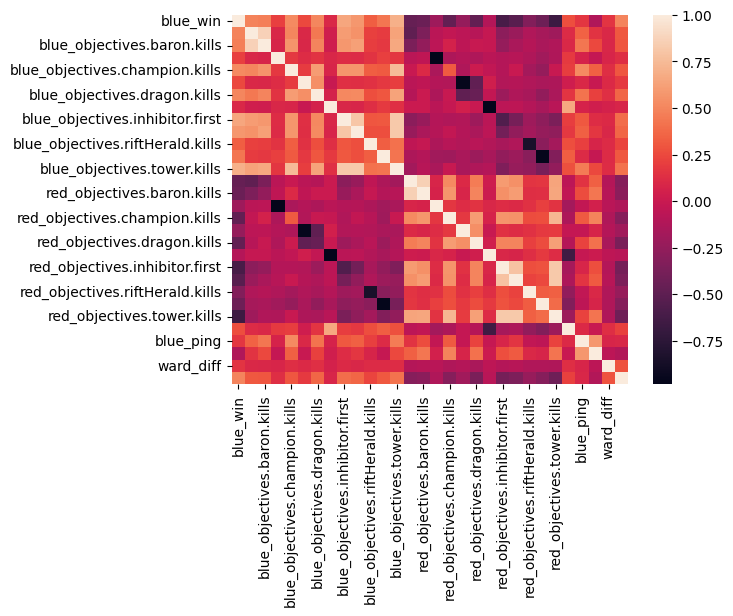

In [12]:
sns.heatmap(data.corr())

In [13]:
# 각각의 컬럼을 팀별로 구분되어 있어 이를 팀별 차이로 변환
wins = data[['blue_win', 'horde_kills', 'ward_diff', 'vision_score_diff']]
blue = data.filter(regex='blue_.*')
red = data.filter(regex='red_.*')

In [14]:
wins

,blue_win,horde_kills,ward_diff,vision_score_diff
0,False,6,2.2,-11.8
1,True,6,1.8,4.8
2,True,6,-0.8,-1.8
3,False,4,-0.8,6.0
4,False,0,0.4,-5.8
...,...,...,...,...
12363,False,-4,-2.4,-13.2
12364,True,6,2.0,1.8
12365,True,-6,0.6,-0.8
12366,True,-6,0.6,-0.8


In [15]:
blue = blue.drop('blue_win', axis=1)

In [16]:
blue

,blue_objectives.baron.first,blue_objectives.baron.kills,blue_objectives.champion.first,blue_objectives.champion.kills,blue_objectives.dragon.first,blue_objectives.dragon.kills,blue_objectives.horde.first,blue_objectives.inhibitor.first,blue_objectives.inhibitor.kills,blue_objectives.riftHerald.kills,blue_objectives.tower.first,blue_objectives.tower.kills,blue_ping
0,False,0,False,23,False,2,True,False,0,1,True,4,29.4
1,False,0,False,36,False,2,True,True,1,1,True,7,44.4
2,True,1,True,38,False,2,True,True,2,1,True,8,41.4
3,False,0,True,40,True,2,True,False,0,0,True,7,57.6
4,False,0,False,7,False,0,True,False,0,0,False,0,17.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,False,0,False,23,False,0,False,False,0,0,False,1,23.6
12364,False,0,True,18,True,2,True,False,0,1,True,6,19.2
12365,True,2,True,48,True,3,False,True,1,0,False,7,55.6
12366,True,2,True,48,True,3,False,True,1,0,False,7,55.6


In [45]:
blue = data[[c for c in data.columns if "blue" in c]]

In [18]:
diff = blue.to_numpy() - red.to_numpy()

In [19]:
diff

array([[-1, -2, -1, ..., 1, -4, -78.80000000000001],
       [0, 0, -1, ..., 1, 6, 21.4],
       [1, 1, 1, ..., 1, 6, 5.399999999999999],
       ...,
       [1, 2, 1, ..., -1, 3, -14.20000000000001],
       [1, 2, 1, ..., -1, 3, -14.20000000000001],
       [0, 0, -1, ..., -1, -3, 5.9999999999999964]], dtype=object)

In [20]:
diff_columns = [x[4:] + "_diff" for x in red.columns]

In [21]:
diff_columns

['objectives.baron.first_diff',
 'objectives.baron.kills_diff',
 'objectives.champion.first_diff',
 'objectives.champion.kills_diff',
 'objectives.dragon.first_diff',
 'objectives.dragon.kills_diff',
 'objectives.horde.first_diff',
 'objectives.inhibitor.first_diff',
 'objectives.inhibitor.kills_diff',
 'objectives.riftHerald.kills_diff',
 'objectives.tower.first_diff',
 'objectives.tower.kills_diff',
 'ping_diff']

In [22]:
diff_df = pd.DataFrame(diff, columns=diff_columns)

In [23]:
diff_df

,objectives.baron.first_diff,objectives.baron.kills_diff,objectives.champion.first_diff,objectives.champion.kills_diff,objectives.dragon.first_diff,objectives.dragon.kills_diff,objectives.horde.first_diff,objectives.inhibitor.first_diff,objectives.inhibitor.kills_diff,objectives.riftHerald.kills_diff,objectives.tower.first_diff,objectives.tower.kills_diff,ping_diff
0,-1,-2,-1,-15,-1,-1,1,-1,-2,1,1,-4,-78.8
1,0,0,-1,19,-1,1,1,1,1,1,1,6,21.4
2,1,1,1,29,-1,-1,1,1,2,1,1,6,5.4
3,-1,-2,1,-11,1,-1,1,-1,-3,-1,1,-4,10.8
4,0,0,-1,-12,-1,-2,1,0,0,0,-1,-4,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,-1,-1,-1,-18,-1,-3,-1,-1,-2,-1,-1,-9,-34.2
12364,0,0,1,12,1,2,1,0,0,1,1,6,3.6
12365,1,2,1,24,1,2,-1,1,1,-1,-1,3,-14.2
12366,1,2,1,24,1,2,-1,1,1,-1,-1,3,-14.2


In [24]:
data_diff = pd.concat([wins, diff_df], axis=1)

In [25]:
data_diff

,blue_win,horde_kills,ward_diff,vision_score_diff,objectives.baron.first_diff,objectives.baron.kills_diff,objectives.champion.first_diff,objectives.champion.kills_diff,objectives.dragon.first_diff,objectives.dragon.kills_diff,objectives.horde.first_diff,objectives.inhibitor.first_diff,objectives.inhibitor.kills_diff,objectives.riftHerald.kills_diff,objectives.tower.first_diff,objectives.tower.kills_diff,ping_diff
0,False,6,2.2,-11.8,-1,-2,-1,-15,-1,-1,1,-1,-2,1,1,-4,-78.8
1,True,6,1.8,4.8,0,0,-1,19,-1,1,1,1,1,1,1,6,21.4
2,True,6,-0.8,-1.8,1,1,1,29,-1,-1,1,1,2,1,1,6,5.4
3,False,4,-0.8,6.0,-1,-2,1,-11,1,-1,1,-1,-3,-1,1,-4,10.8
4,False,0,0.4,-5.8,0,0,-1,-12,-1,-2,1,0,0,0,-1,-4,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,False,-4,-2.4,-13.2,-1,-1,-1,-18,-1,-3,-1,-1,-2,-1,-1,-9,-34.2
12364,True,6,2.0,1.8,0,0,1,12,1,2,1,0,0,1,1,6,3.6
12365,True,-6,0.6,-0.8,1,2,1,24,1,2,-1,1,1,-1,-1,3,-14.2
12366,True,-6,0.6,-0.8,1,2,1,24,1,2,-1,1,1,-1,-1,3,-14.2


In [26]:
data_diff.corr()

,blue_win,horde_kills,ward_diff,vision_score_diff,objectives.baron.first_diff,objectives.baron.kills_diff,objectives.champion.first_diff,objectives.champion.kills_diff,objectives.dragon.first_diff,objectives.dragon.kills_diff,objectives.horde.first_diff,objectives.inhibitor.first_diff,objectives.inhibitor.kills_diff,objectives.riftHerald.kills_diff,objectives.tower.first_diff,objectives.tower.kills_diff,ping_diff
blue_win,1.000000,0.270790,0.162248,0.491109,0.549484,0.571851,0.209457,0.844246,0.243997,0.575152,0.100173,0.707649,0.698330,0.341810,0.430941,0.854963,0.309015
horde_kills,0.270790,1.000000,0.130632,0.213825,0.098641,0.089052,0.178579,0.281182,0.026022,0.149250,0.657438,0.204648,0.193885,0.274709,0.331422,0.307107,0.116982
ward_diff,0.162248,0.130632,1.000000,0.281629,0.113357,0.109734,0.083377,0.219527,0.104373,0.170814,0.059074,0.119368,0.107689,0.123460,0.118371,0.158375,0.164038
vision_score_diff,0.491109,0.213825,0.281629,1.000000,0.358299,0.371451,0.128507,0.522768,0.188003,0.428928,0.084155,0.442314,0.450561,0.243571,0.313140,0.526480,0.220722
objectives.baron.first_diff,0.549484,0.098641,0.113357,0.358299,1.000000,0.889625,0.092570,0.521553,0.097870,0.363125,0.019685,0.580299,0.561658,0.160881,0.190791,0.599971,0.234420
objectives.baron.kills_diff,0.571851,0.089052,0.109734,0.371451,0.889625,1.000000,0.080740,0.519652,0.090527,0.371023,0.015308,0.572059,0.600398,0.143884,0.177154,0.601085,0.242140
objectives.champion.first_diff,0.209457,0.178579,0.083377,0.128507,0.092570,0.080740,1.000000,0.264641,0.112307,0.165227,0.084311,0.128554,0.126237,0.147400,0.200067,0.189966,0.099301
objectives.champion.kills_diff,0.844246,0.281182,0.219527,0.522768,0.521553,0.519652,0.264641,1.000000,0.260481,0.599333,0.086313,0.655291,0.622844,0.379923,0.440628,0.801964,0.324716
objectives.dragon.first_diff,0.243997,0.026022,0.104373,0.188003,0.097870,0.090527,0.112307,0.260481,1.000000,0.608582,-0.025115,0.142561,0.141846,0.137053,0.168057,0.212846,0.117573
objectives.dragon.kills_diff,0.575152,0.149250,0.170814,0.428928,0.363125,0.371023,0.165227,0.599333,0.608582,1.000000,0.040076,0.469072,0.471613,0.216339,0.304449,0.562628,0.248390


In [27]:
data_diff.corr()['objectives.champion.first_diff']

blue_win                            0.209457
horde_kills                         0.178579
ward_diff                           0.083377
vision_score_diff                   0.128507
objectives.baron.first_diff         0.092570
objectives.baron.kills_diff         0.080740
objectives.champion.first_diff      1.000000
objectives.champion.kills_diff      0.264641
objectives.dragon.first_diff        0.112307
objectives.dragon.kills_diff        0.165227
objectives.horde.first_diff         0.084311
objectives.inhibitor.first_diff     0.128554
objectives.inhibitor.kills_diff     0.126237
objectives.riftHerald.kills_diff    0.147400
objectives.tower.first_diff         0.200067
objectives.tower.kills_diff         0.189966
ping_diff                           0.099301
Name: objectives.champion.first_diff, dtype: float64

<Axes: >

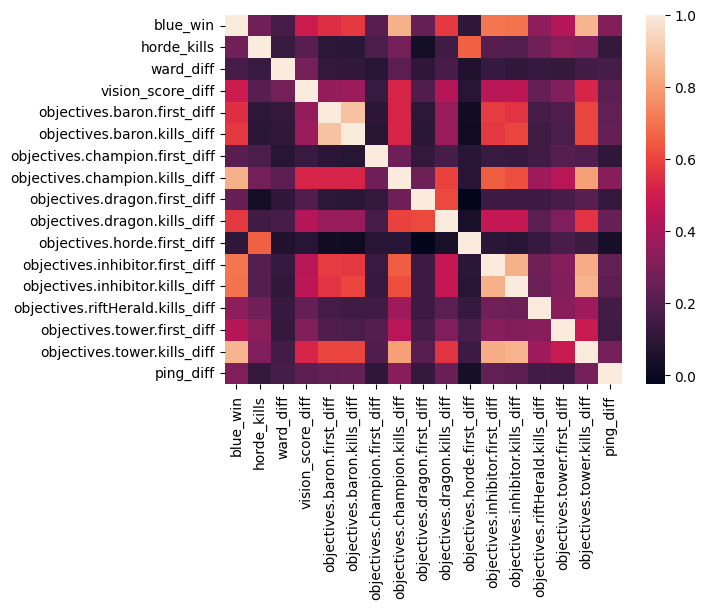

In [28]:
sns.heatmap(data_diff.corr())

In [107]:
corr_matrix = data_diff.corr()
np.fill_diagonal(corr_matrix.values, np.nan)

In [108]:
corr_matrix

,blue_win,horde_kills,ward_diff,vision_score_diff,objectives.baron.first_diff,objectives.baron.kills_diff,objectives.champion.first_diff,objectives.champion.kills_diff,objectives.dragon.first_diff,objectives.dragon.kills_diff,objectives.horde.first_diff,objectives.inhibitor.first_diff,objectives.inhibitor.kills_diff,objectives.riftHerald.kills_diff,objectives.tower.first_diff,objectives.tower.kills_diff,ping_diff
blue_win,NaN,0.270790,0.162248,0.491109,0.549484,0.571851,0.209457,0.844246,0.243997,0.575152,0.100173,0.707649,0.698330,0.341810,0.430941,0.854963,0.309015
horde_kills,0.270790,NaN,0.130632,0.213825,0.098641,0.089052,0.178579,0.281182,0.026022,0.149250,0.657438,0.204648,0.193885,0.274709,0.331422,0.307107,0.116982
ward_diff,0.162248,0.130632,NaN,0.281629,0.113357,0.109734,0.083377,0.219527,0.104373,0.170814,0.059074,0.119368,0.107689,0.123460,0.118371,0.158375,0.164038
vision_score_diff,0.491109,0.213825,0.281629,NaN,0.358299,0.371451,0.128507,0.522768,0.188003,0.428928,0.084155,0.442314,0.450561,0.243571,0.313140,0.526480,0.220722
objectives.baron.first_diff,0.549484,0.098641,0.113357,0.358299,NaN,0.889625,0.092570,0.521553,0.097870,0.363125,0.019685,0.580299,0.561658,0.160881,0.190791,0.599971,0.234420
objectives.baron.kills_diff,0.571851,0.089052,0.109734,0.371451,0.889625,NaN,0.080740,0.519652,0.090527,0.371023,0.015308,0.572059,0.600398,0.143884,0.177154,0.601085,0.242140
objectives.champion.first_diff,0.209457,0.178579,0.083377,0.128507,0.092570,0.080740,NaN,0.264641,0.112307,0.165227,0.084311,0.128554,0.126237,0.147400,0.200067,0.189966,0.099301
objectives.champion.kills_diff,0.844246,0.281182,0.219527,0.522768,0.521553,0.519652,0.264641,NaN,0.260481,0.599333,0.086313,0.655291,0.622844,0.379923,0.440628,0.801964,0.324716
objectives.dragon.first_diff,0.243997,0.026022,0.104373,0.188003,0.097870,0.090527,0.112307,0.260481,NaN,0.608582,-0.025115,0.142561,0.141846,0.137053,0.168057,0.212846,0.117573
objectives.dragon.kills_diff,0.575152,0.149250,0.170814,0.428928,0.363125,0.371023,0.165227,0.599333,0.608582,NaN,0.040076,0.469072,0.471613,0.216339,0.304449,0.562628,0.248390


<BarContainer object of 17 artists>

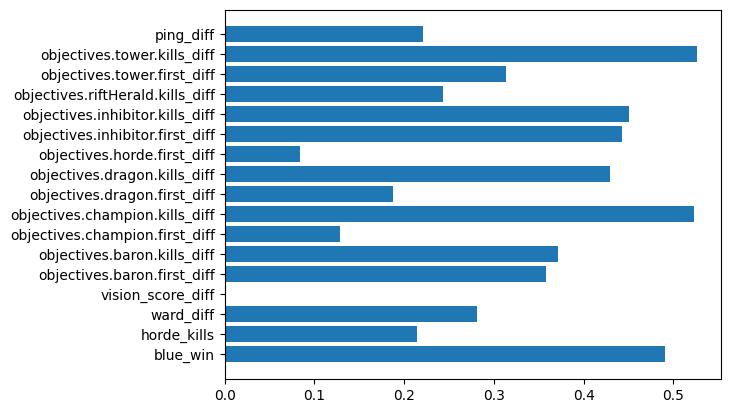

In [110]:
plt.barh(corr_matrix.vision_score_diff.index, corr_matrix.vision_score_diff.values)

### 시야 가설
- 예상했던 것보다 다른 부분들과 시야 점수와의 상관관계가 낮음
- 그러나 타워 제거나 챔피언 킬에는 0.5 이상의 상관관계를 보여줌
- 승리와도 거의 0.5에 가까운 상관관계를 보여줌

In [38]:
def visual(data, colname):
    win = data[colname][data.blue_win == 1]
    lose = data[colname][data.blue_win == 0]
    
    plt.title(colname)
    plt.hist(win, label="win", alpha=0.5)
    plt.hist(lose, label="lose", alpha=0.5)
    plt.legend()
    plt.grid()
    plt.show()

### 시각화
- 승리 여부에 따른 feature의 분포 시각화

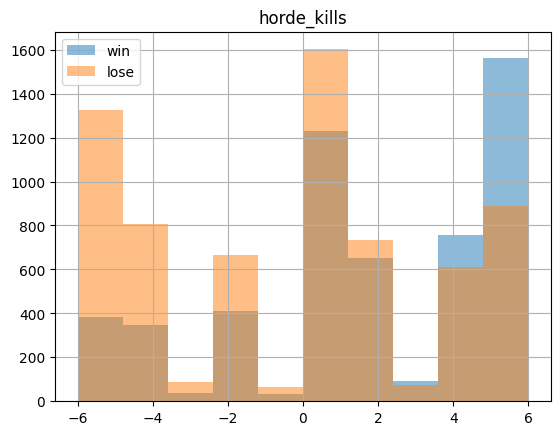

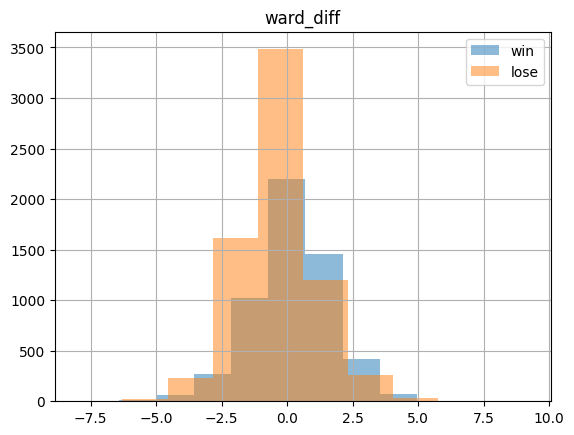

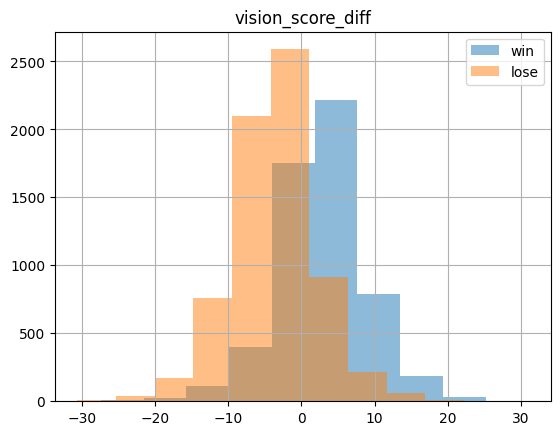

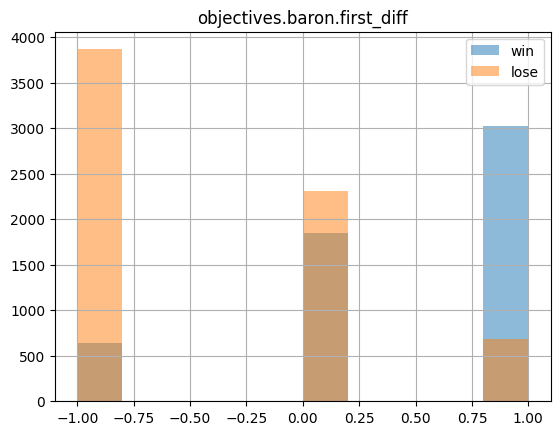

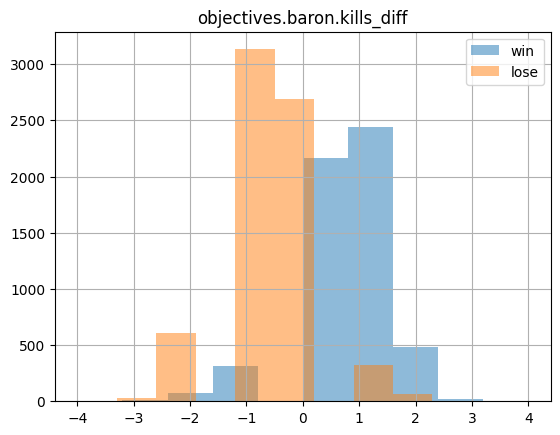

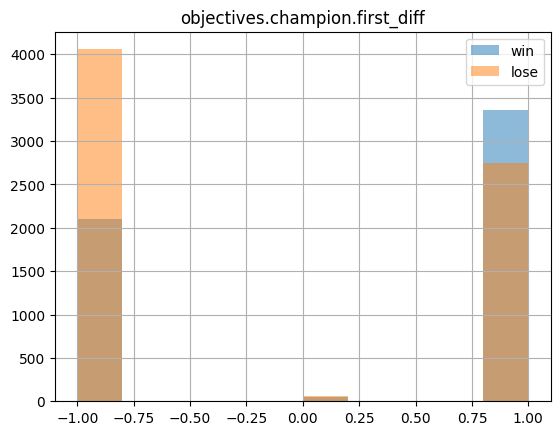

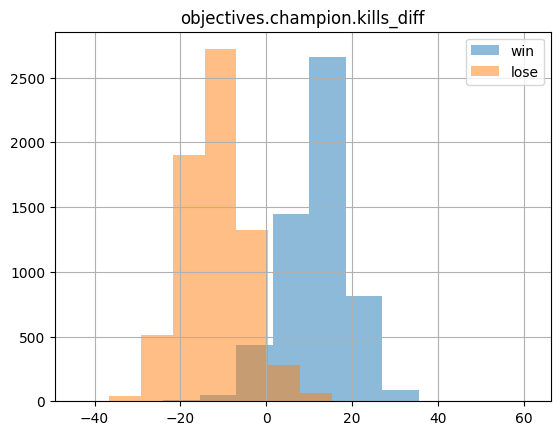

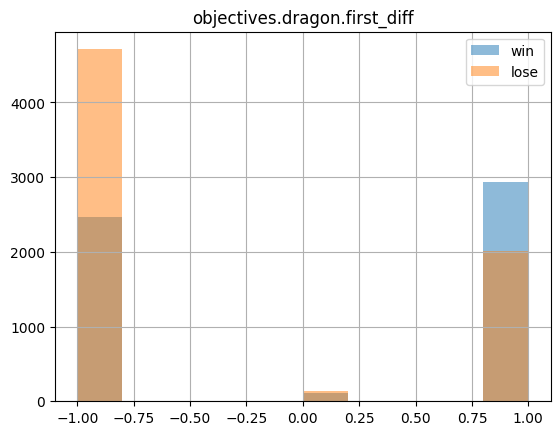

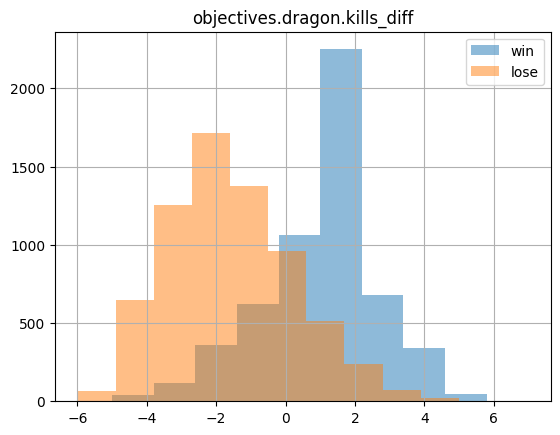

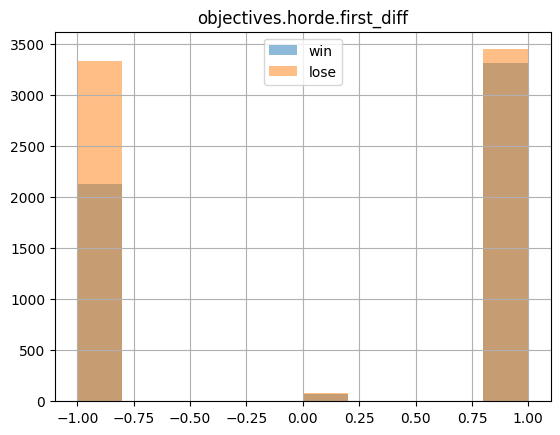

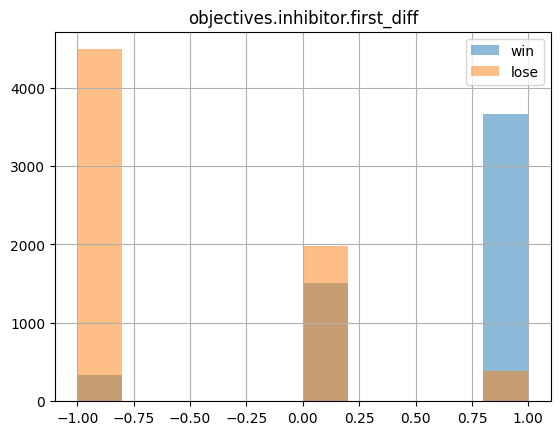

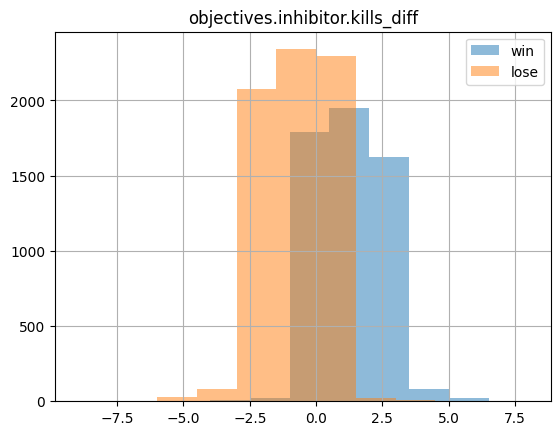

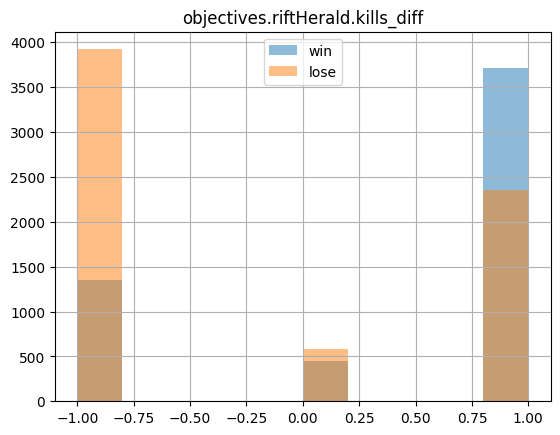

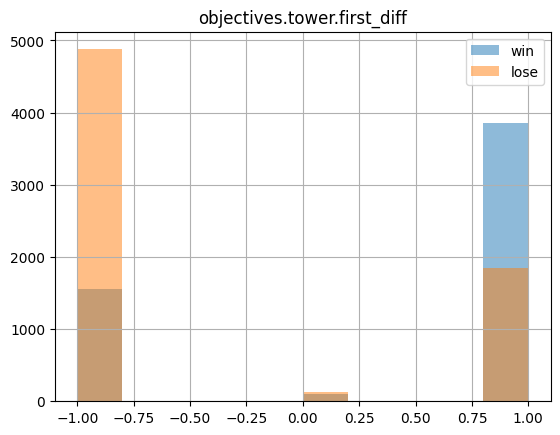

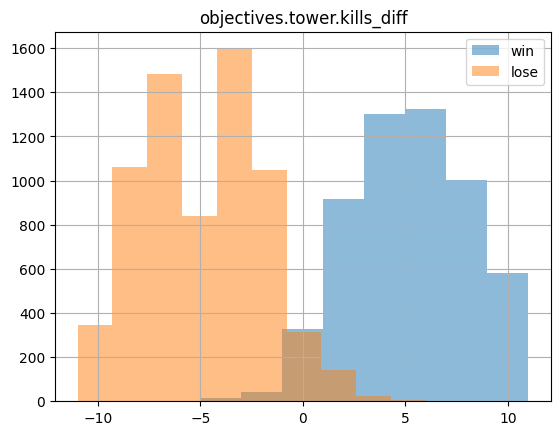

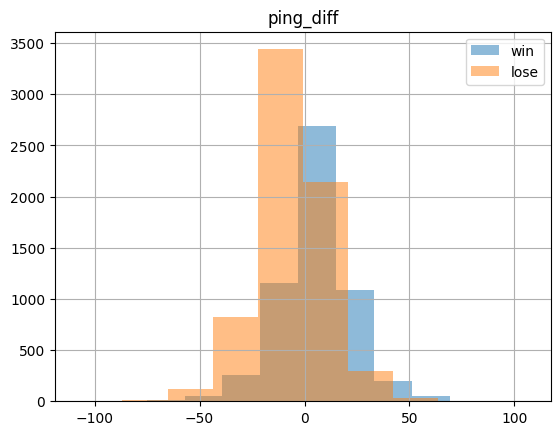

In [114]:
for idx, i in enumerate(data_diff.columns):
    if idx == 0:
        pass
    else:
        visual(data_diff, i)

### 시각화
- 시각화를 해본 결과 타워의 철거갯수 차이가 승리 여부에 따라 가장 극명하게 나뉘어짐
- 예상했던 것과 달리 와드 구매 갯수와 핑의 횟수 차이는 승리에 따라 큰 차이를 보여주지 않음

<BarContainer object of 17 artists>

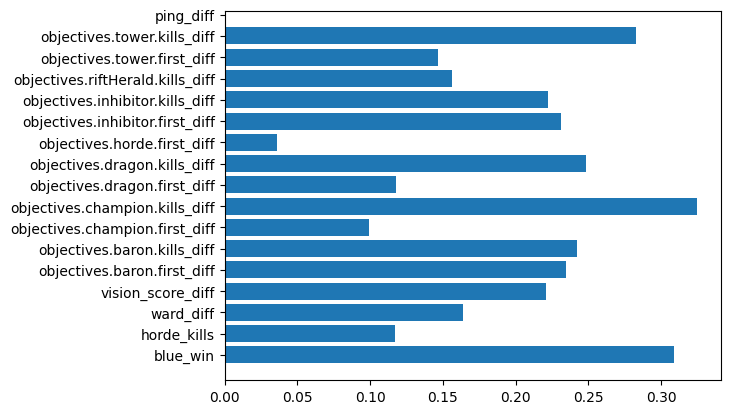

In [111]:
plt.barh(corr_matrix.ping_diff.index, corr_matrix.ping_diff.values)

### 핑 가설
- 예상했던 것과 달리 핑과 승리의 상관관계가 낮음
- 하지만 진 팀이 비교적 더 많은 핑을 치는 것으로 시각화를 통해 추정함

<BarContainer object of 17 artists>

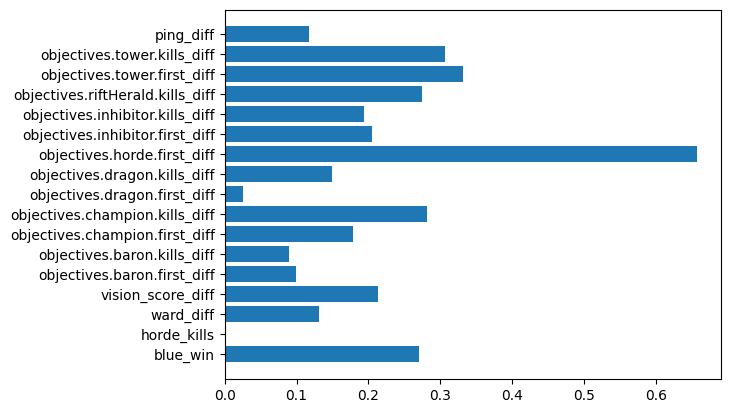

In [112]:
plt.barh(corr_matrix.horde_kills.index, corr_matrix.horde_kills.values)

<BarContainer object of 17 artists>

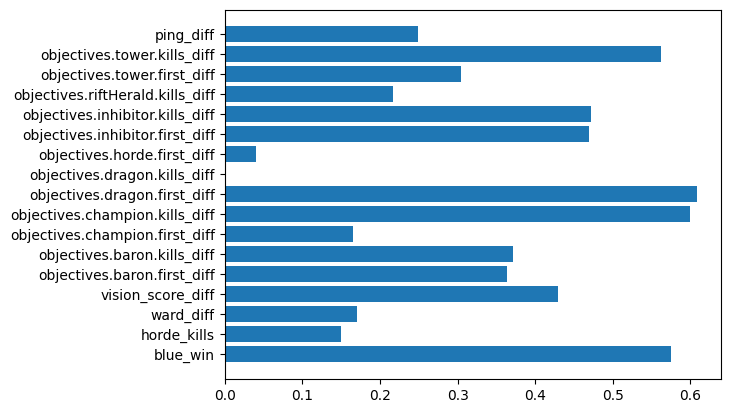

In [113]:
plt.barh(corr_matrix['objectives.dragon.kills_diff'].index, corr_matrix['objectives.dragon.kills_diff'].values)

## 공허 유충
- 예상했던 것과 달리 공허 유충을 많이 먹는 것과 승리와의 상관관계는 용을 먹는 것보다 낮음
- 이를 통해 여전히 용이 공허 유충보다 중요하다고 추정됨

### 모델링
- 랜덤포레스트 모델을 사용하여 분류 진행

In [91]:
train_x, test_x, train_y, test_y = train_test_split(data_diff.drop('blue_win', axis=1), data_diff.blue_win,
                                                    train_size=0.3, random_state=42)

In [92]:
rdf = RandomForestClassifier(random_state=42)

In [93]:
rdf.fit(train_x, train_y)

RandomForestClassifier(random_state=42)

In [94]:
pred = rdf.predict(test_x)

In [95]:
f1_score(test_y, pred)

0.9742517317997648